In [285]:
!pip3 install -U openai 

In [286]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import json
from openai import OpenAI
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
import re
import warnings

In [287]:
API_KEY = "sk-f86318f6dea54fd6a11b19fcc3a7b81f"

In [288]:
#dataset = load_dataset('csv', data_files='/Users/faresg/Desktop/MSc AI A&I/ML for Actionable Decison Making/Project/data/MLHC_train_classification_3.csv')
dataset = load_dataset('csv', data_files='/Users/faresg/Desktop/MSc AI A&I/ML for Actionable Decison Making/Project/data/MLHC_test_classification_2.csv')

# Function to format each example into a training prompt
def format_example(example):
    return {"text_data": example["text_data"]}

In [289]:
# Apply formatting to the dataset
print(len(dataset["train"]))
print(dataset["train"][0]["text_data"])  # Inspect one formatted example
print(dataset["train"][0]["triage_level"])  # Inspect one formatted example

train_dataset = dataset["train"].select(range(100))  
print(len(train_dataset))

1033
A 68.0-year-old male arrived by private vehicle at the ED with an non-injury visit. The patient reported the following primary complaint(s): Foot and toe pain, ache, soreness, di..., Injury, other and unspecified, of foo..., Direct admission to hospital. Recorded vital signs include temperature 98.1, pulse 106.0, blood pressure 103.0/74.0, respiratory rate 18.0, and O2 saturation 100.0%. Pain scale was noted as 9.0. The patient has a total of 4.0 chronic condition(s), including: Diabetes (Unspecified), Hyperlipidemia, Hypertension, Substance abuse. Possible cause(s) related to this visit: Other cause of strike by thrown, projected or falling object.
Urgent.
100


In [290]:
triage_levels = dataset["train"][:]["triage_level"]
triage_levels = list(set(triage_levels))
triage_levels

['Nonurgent.', 'Semi-urgent.', 'Immediate.', 'Urgent.', 'Emergent.']

In [291]:
system_prompt_1 = """
You are an expert ER Doctor who will assign medical triage based on the Emergency Severity Index (ESI) classification. You will carefully evaluate the following patient summary and assign an appropriate triage score. 
Patient Summary:
"""

system_prompt_2 = """

Use ESI classification for triaging, which follows the following framework:
The ESI assigns patients to one of five levels based on the severity of their condition and the medical resources they are likely to require:
Level 1 (Immediate): Immediate, life-saving intervention required without delay. Examples - Cardiac arrest; Pulseless/Unresponsive; Profound hypotension or hypoglycemia; Major trauma with hemodynamic instability
Level 2 (Emergent): High risk of deterioration, or signs of a time-critical problem. Examples - Cardiac-related chest pain; Severe Asthma exacerbation (stable vitals but in significant distress); Altered mental status; Potential stroke (Alert but high risk)
Level 3 (Urgent): Stable, with multiple types of resources needed to investigate or treat (such as lab tests plus diagnostic imaging). Examples - Non-critical Abdominal pain needing labs + CT ; High fever with cough; Persistent headache; Stable orthopedic injury needing imaging + Possible reduction; Moderate respiratory complaint needing labs, nebulizer, and possible imaging
Level 4 (Semi-Urgent): Stable, with only one type of resource anticipated (such as only an x-ray, or only sutures). Examples - Simple extermity injury needing a single x-ray; Sore throat needing one swab; UTI needing only a urine test; Rabies vaccination
Level 5 (Non-Urgent): Stable, with no resources anticipated except oral or topical medications, or prescriptions. Examples - Medication refill; Minor rash needing visual exam only; Suture removal; Foreign body in eye; Stable earache with exam and antibiotic prescription
 
ESI Decision Framework: Goal - Indentify who needs to be seen immediately and anticipate the resources needed for each patient.
STEP 1: Check for Immediate Life-Threatening Conditions (ESI Level 1)
Assess Airway/Breathing/Circulation (ABCs) - Apneic or pulseless? Severe respiratory distress? Profound hypotension? Requires immediate lifesaving intervention (e.g., intubation, emergent fluid resuscitation)? Assign ESI Level 1.
Unresponsive Patients - No verbal response or follows no commands (acutely)? Requires painful stimulus to respond? Assign ESI Level 1.

STEP 2: Determine if High-Risk (ESI Level 2)
If not ESI 1, check:
High-Risk Symptoms - Possible stroke, chest pain suspicious for ACS, ectopic pregnancy, suicidal/homicidal ideation, immunocompromised with fever? Assign ESI Level 2.
Acute Change in Mental Status - New confusion, lethargy, agitation, or disorientation? Assign ESI Level 2.
Severe Pain or Distress - Pain severity ≥7/10 with signs of systemic distress (e.g., sickle cell crisis)? Assign ESI Level 2.

STEP 3: Estimate Number of Resources (ESI Levels 3, 4, 5)
If not ESI Level 1 or Level 2, predict how many different resources will be needed for diagnosis/treatment:
ESI Level 3: Likely needs 2 or more resources - e.g., labs + imaging, IV meds + ultrasound, consults 
ESI Level 4: Likely needs 1 resource - e.g., single X-ray or strep test only
ESI Level 5: Likely needs 0 resources - e.g., minor complaint needing exam & simple prescription
What counts as a 'resource'? Labs (all labs = 1), any imaging (X-ray, CT, ultrasound), IV fluids/meds, consults, procedures
What does not count as a resource?: Physical exam alone, PO meds at triage, simple wound care, phone call to PCP, tetanus shot

STEP 4: Evaluate Vital Signs
For ESI Level 3 patients, check full vitals (HR, RR, BP, SpO₂).
Reassess if vitals are abnormal for age/condition. Abnormal values include heart rate > 100 bpm, respiratory rate > 20 breaths/min, oxygen saturation ≤ 92%, systolic blood pressure < 90 mmHg (hypotension), and temperature ≥ 38.0°C (100.4°F) or ≤ 36.0°C (96.8°F). If vitals suggest instability, up-triage to ESI Level 2.


Use should also assign a trigage severity index which will be used by the EHR for internal routing. The triage severity index is as follows:
II: Level 1 (Immediate)
III: Level 2 (Emergent)
VI: Level 3 (Urgent)
VII: Level 4 (Semi-Urgent)
IX: Level 5 (Non-Urgent)

Evaluation Instructions:
After reviewing the patient summary, follow these reasoning steps to assign the triage level:
1. List all the key symptoms and risk factors present in the case.
2. Explain how each symptom or factor contributes to the overall triage decision.
3. Describe any assumptions you make to fill in missing data or clarify uncertainties.
4. Identify any gaps or missing information that prevent a confident diagnosis.
5. Assign Final Triage Level based on your reasoning and explain why this is the most appropriate classification.
6. If you cannot make a confident decision due to missing or unclear data, state “I cannot make a decision” and output NA as the triage level.

 
Verification and Reassessment:
After providing your triage reasoning, follow these steps:
1. Double-check that all symptoms and risk factors have been accounted for.
2. Identify any assumptions you made and clarify areas where certainty is lower.
3. Correct any discrepancies or contradictions.
4. Provide a brief summary of the verification process.
 
Important Notes:
Always ensure medical accuarcy. Use clear, professional language. 
Provide a structured, logical chain of thought, each in their own reasoning step.

Please output the appropriate number of "reasoning_steps", "triage_severity_index" and "triage_level" in json format. 

EXAMPLE INPUT: 
A 25.0-year-old female arrived by private vehicle at the ED with an non-injury visit. The patient reported the following primary complaint(s): Toothache, Edema. Recorded vital signs include temperature 98.1, pulse 96.0, blood pressure 108.0/64.0, respiratory rate 18.0, and O₂ saturation 98.0%. Pain scale was noted as 6.0. The patient has a total of 2.0 chronic condition(s), including: none. Possible cause(s) related to this visit: no specific causes reported.

EXAMPLE OUTPUT:
'''json
{
  "reasoning_step_1": "Identify the chief complaint(s): The patient reports a toothache with accompanying swelling (edema). Pain is rated as 6/10, which indicates moderate pain.",
  "reasoning_step_2": "Assess vital signs: Temperature is 98.1°F, pulse 96 bpm, blood pressure 108/64 mm Hg, respiratory rate 18 breaths/minute, and O2 saturation 98%. All are within normal or near-normal ranges, suggesting hemodynamic stability and no immediate high-risk abnormalities.",
  "reasoning_step_3": "Evaluate the nature of symptoms: The moderate toothache and swelling could indicate an infection or abscess but does not, in itself, suggest an immediately life-threatening condition (e.g., no airway compromise, no signs of severe systemic distress). The patient’s pain score (6/10) is noteworthy, but it is below the threshold typically considered ‘severe’ for ESI triage (≥7/10) unless associated with systemic red flags.",
  "reasoning_step_4": "Determine the urgency and resources: The patient does not meet ESI Level 1 or 2 criteria (no high-risk indicators, no severe pain ≥7/10, no altered mental status). She is likely to need at least one resource (e.g., possible dental or surgical consult, or a single imaging study) rather than multiple resources. Consequently, she does not rise to ESI level 3, which generally involves two or more resources.",
  "reasoning_step_5": "Conclusion: Given the stable vital signs, moderate pain, and probable need for only one resource (such as an X-ray or a consult), the appropriate triage level is ESI Level 4.",
  "triage_severity_index": "VI",
  "triage_level": "Level 3",
  "verification_and_reassessment": "All key symptoms and risk factors have been considered, and the decision is supported by the severity of the patient's condition. No discrepancies or contradictions are present."
}
'''
"""

In [292]:
triage_mapping = {"Level 1" : "Immediate",
                  "Level 2" : "Emergent",
                  "Level 3" : "Urgent",
                  "Level 4" : "Semi-urgent",
                  "Level 5" : "Nonurgent"
}

In [293]:
client = OpenAI(
    api_key=API_KEY,
    base_url="https://api.deepseek.com",
)

In [294]:
def call_deepseek_v3(user_prompt):
    # Compose your complete input prompt (you can modify system_prompt_1 and system_prompt_2 as needed)
    input_prompt = system_prompt_1 + user_prompt + system_prompt_2
    messages = [{"role": "user", "content": input_prompt}]
    
    # Call the OpenAI API
    response = client.chat.completions.create(
        model="deepseek-chat",         # DeepSeek V3
        messages=messages,
        logprobs=True,
        top_logprobs=20,                    
        temperature=0.14,                  
        response_format={'type': 'json_object'},  # Enforce structured JSON output
    )

    out_content = json.loads(response.choices[0].message.content)
    out_logprobs = response.choices[0].logprobs
    triage_token = out_content.get('triage_severity_index').strip()

    # Use next() with a generator expression to find the token
    token_obj = next((token for token in out_logprobs.content if token.token.strip() == triage_token), None)

    if token_obj is not None:
        probability_list = np.exp([token_obj.top_logprobs[i].logprob for i in range(len(token_obj.top_logprobs))])
        probability = probability_list / np.sum(probability_list)
    else:
        probability = None
        
    return {"text": out_content, "probability": probability[0]}

In [295]:
triage_value = {"Immediate": 5,
                "Emergent": 4,
                "Urgent": 3,
                "Semi-urgent": 2,
                "Nonurgent": 1,
                "NA": 0
}

In [320]:
import textwrap
def pretty_print_decision(decision: dict):
    print("Decision:")
    for key, value in decision['text'].items():
        formatted_key = key.replace("_", " ").capitalize()
        if key == "triage_level":
            value = triage_mapping.get(value)
        #print(f"\n{formatted_key}:")
        out1 = f"\n{formatted_key}:"
        print("\n".join(textwrap.wrap(out1, width=120)))
        out2 = f"    {value}"
        print("\n".join(textwrap.wrap(out2, width=120)))
    print("\nProbability of Triage Level:")
    print(f"    {decision['probability']:.2%}")

In [297]:
def plot_conf_matrix(cm, flag, text_labels=None):
    plt.figure(figsize=(6, 5))
    if flag == "multi":
        text_labels = ["NA", "Nonurgent", "Semi-urgent", "Urgent", "Emergent", "Immediate"] 
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=text_labels, yticklabels=text_labels)
    elif flag == "binary":
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=text_labels, yticklabels=text_labels)
    else:
        print("Invalid flag. Please use 'multi' for multi-class classification and 'binary' for binary classification.")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [298]:
output_df = pd.DataFrame(columns=[
    "clinical_note", 
    "true_triage", 
    "predicted_triage", 
    "triage_severity_index", 
    "reasoning", 
    "verification_and_reassessment", 
    "probability"
])

In [299]:
def save_to_df(df, clinical_note, true_triage, model_output):
    # Extract ready information from the model output
    predicted_triage = triage_mapping.get(model_output.get("text")["triage_level"])
    probability_score = model_output.get("probability")
    triage_severity_index = model_output.get("text")["triage_severity_index"]
    verification_and_reassessment = model_output.get("text")["verification_and_reassessment"]

    # Dynamically extract all reasoning steps and sort them by their step number
    reasoning_steps = []
    for key, value in  model_output.get("text").items():
        if key.startswith("reasoning_step_"):
            step_num = int(re.search(r"reasoning_step_(\d+)", key).group(1))
            reasoning_steps.append((step_num, value))

    reasoning_steps.sort(key=lambda x: x[0])
    combined_reasoning = "\n".join([step for _, step in reasoning_steps])

    # Create a new row dictionary with all columns filled
    new_row = {
        "clinical_note": clinical_note,
        "true_triage": true_triage,
        "predicted_triage": predicted_triage,
        "triage_severity_index": triage_severity_index,
        "reasoning": combined_reasoning,
        "verification_and_reassessment": verification_and_reassessment,
        "probability": probability_score
    }

    # Append the new row to the DataFrame & return it
    new_df = pd.DataFrame([new_row])
    df = pd.concat([df, new_df], ignore_index=True)
    return df

In [300]:
def complete_evaluator(evaluation_data, output_df, show_progress=False):
    true_labels = []
    predictions = []
    all_probabilities = []

    #hide future warnings
    warnings.simplefilter("ignore", FutureWarning)

    counter = 0
    data_len = len(evaluation_data)
    for case in evaluation_data:
        if show_progress:
            sys.stdout.write(f'\rProgress: {round((counter/data_len)*100)}%')
            sys.stdout.flush()
            counter += 1  
        clinical_note = case["text_data"]
        true_label = case["triage_level"]

        model_output = call_deepseek_v3(clinical_note)
        
        predicted_label = triage_mapping.get(model_output.get("text")["triage_level"])
        if predicted_label is None:
            predicted_label = "NA"
        label_prob = model_output.get("probability")

        #SAVE TO DF#
        output_df = save_to_df(output_df, clinical_note, true_label, model_output)
        ### END ####

        true_labels.append(true_label)
        predictions.append(predicted_label)
        all_probabilities.append(label_prob)

        
        if show_progress and (counter == data_len):
            sys.stdout.write(f'\rProgress: 100%')
            sys.stdout.flush()
            print("\n")
    
    levels = list(triage_mapping.values())+["NA"] #is this correct???

    return true_labels, predictions, all_probabilities, levels, output_df

In [301]:
def global_metrics(true_labels, predictions, all_probabilities, levels, number_of_classes):
    # --- Global Metrics ---
    global_accuracy = accuracy_score(true_labels, predictions)

    # Build a probability matrix: each row corresponds to an example, and the columns follow the ordering in "levels"
    prob_matrix = np.array([[probs for level in levels] for probs in all_probabilities])
    # roc_auc_score for multi-class classification requires the true labels as integers and the probability matrix.
    try:
        global_auc = roc_auc_score(true_labels, prob_matrix, multi_class="ovr", average="macro")
    except ValueError:
        global_auc = None  # In case there is a class missing in predictions

    global_conf_matrix = confusion_matrix([triage_value.get(label) for label in true_labels], [triage_value.get(pred) for pred in predictions], labels=range(len(levels)))
    mean_probability = np.mean(all_probabilities)

    underreport = 0
    overreport = 0
    total_wrong = 0

    for i in range(len(true_labels)):
        pred_label_value = triage_value.get(predictions[i])
        true_label_value = triage_value.get(true_labels[i])
        # Compare predicted and true level (both assumed numeric or ordered)
        if pred_label_value < true_label_value:
            underreport += 1
            total_wrong += 1
        elif pred_label_value > true_label_value:
            overreport += 1
            total_wrong += 1
        else:
            continue
        
    underreport_pct = (underreport / total_wrong) * 100 if total_wrong > 0 else 0
    overreport_pct = (overreport / total_wrong) * 100 if total_wrong > 0 else 0
    
    print("Global Metrics:")
    print(f"Accuracy: {global_accuracy:.3f}")
    if global_auc is not None:
        print(f"AUC: {global_auc:.3f}")
    else:
        print("AUC: Not computable (check distribution of classes)")
    print("Confusion Matrix:")
    print(global_conf_matrix)

    plot_conf_matrix(global_conf_matrix, flag="multi")

    print(f"Mean Predicted Probability: {mean_probability:.3f}")
    print(f"Undereporting % (predicted < true) of wrong predictions: {underreport_pct:.2f}%")
    print(f"Overreporting % (predicted > true) of wrong predictions: {overreport_pct:.2f}%")

In [302]:
def per_triage_level_metrics(true_labels, predictions, all_probabilities, levels):
    print("\nPer Triage Level Metrics:")
    for level in levels:
        # Filter indices where the true label is equal to the current level.
        indices = [i for i, lab in enumerate(true_labels) if lab == level]
        if len(indices) == 0:
            print(f"\nNo cases of Triage Level: {level}\n")
            continue
        
        # Get true and predicted for this subset.
        true_subset = [true_labels[i] for i in indices]
        pred_subset = [predictions[i] for i in indices]
        
        # Accuracy for current triage level: proportion of cases correctly predicted within the subset.
        level_accuracy = accuracy_score(true_subset, pred_subset)
        
        # For binary AUC (current level vs all others), create binary labels and probability list.

        binary_true = [1 if lab == level else 0 for lab in true_labels]
        
        level_probs = [probs for probs in all_probabilities]
        # AUC is only defined if both classes are present in the binary labels.
        try:
            level_auc = roc_auc_score(binary_true, level_probs)
        except ValueError:
            level_auc = None
        
        # Build a binary confusion matrix:
        # Predicted positive if predicted label equals current level, negative otherwise.
        binary_pred = [1 if pred == level else 0 for pred in predictions]
        level_conf_matrix = confusion_matrix(binary_pred, binary_true)
        
        # Compute underreporting and overreporting rates for cases where the true level is 'level'.
        # Here we assume the triage levels are ordinal so that a lower number means lower severity.
        underreport = 0
        overreport = 0
        total_wrong = 0

        for i in range(len(true_subset)):
            pred_label_value = triage_value.get(pred_subset[i])
            true_label_value = triage_value.get(true_subset[i])
            # Compare predicted and true level (both assumed numeric or ordered)
            if pred_label_value < true_label_value:
                underreport += 1
                total_wrong += 1
            elif pred_label_value > true_label_value:
                overreport += 1
                total_wrong += 1
            else:
                continue
        
        underreport_pct = (underreport / total_wrong) * 100 if total_wrong > 0 else 0
        overreport_pct = (overreport / total_wrong) * 100 if total_wrong > 0 else 0
        
        # Mean probability for current triage level among examples with true label equal to level.
        mean_prob_level = np.mean([all_probabilities[i] for i in indices])
   
        print(f"\nTriage Level: {level}")
        print(f"Accuracy: {level_accuracy:.3f}")
        if level_auc is not None:
            print(f"AUC: {level_auc:.3f}")
        else:
            print("AUC: Not computable (check distribution of classes)")
        print("Confusion Matrix:")
        print(level_conf_matrix)

        plot_conf_matrix(level_conf_matrix, flag="binary", text_labels=["Not " + level, level])
        
        print(f"Mean Predicted Probability: {mean_prob_level:.3f}")
        print(f"Undereporting % (predicted < true) of wrong predictions: {underreport_pct:.2f}%")
        print(f"Overreporting % (predicted > true) of wrong predictions: {overreport_pct:.2f}%")

In [303]:
true_labels, predictions, all_probabilities, levels, output_df = complete_evaluator(train_dataset, output_df, show_progress=True)
output_df.to_csv("output_df.csv", index=False)

Progress: 100%



In [304]:
#how many cases of each unique value
class_labels, class_counts = np.unique(true_labels, return_counts=True)
print("Class Labels:", class_labels)
print("Class Counts:", class_counts)
number_of_classes = len(class_labels)

Class Labels: ['Emergent.' 'Immediate.' 'Nonurgent.' 'Semi-urgent.' 'Urgent.']
Class Counts: [18  4  3 29 46]


['Urgent', 'Emergent', 'Urgent', 'Nonurgent', 'Semi-urgent', 'Semi-urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Emergent', 'Urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Urgent', 'Urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Emergent', 'Semi-urgent', 'Emergent', 'Semi-urgent', 'Semi-urgent', 'Urgent', 'Emergent', 'Urgent', 'Immediate', 'Urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Semi-urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Semi-urgent', 'Urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Semi-urgent', 'Nonurgent', 'Urgent', 'Emergent', 'Urgent', 'Urgent', 'Semi-urgent', 'Emergent', 'Urgent', 'Urgent', 'Urgent', 'Semi-urgent', 'Urgent', 'Emergent', 'Urgent', 'Emergent', 'Emergent', 'Emergent', 'Urgent', 'Semi-urgent', 'Urgent', 'Semi-urgent', 'Urgent'

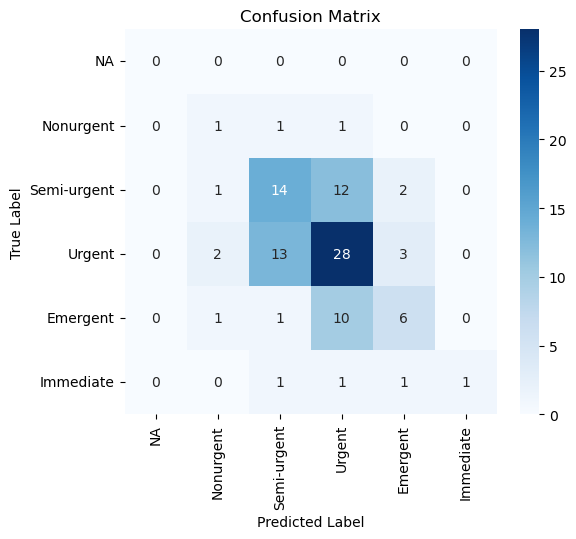

Mean Predicted Probability: 1.000
Undereporting % (predicted < true) of wrong predictions: 62.00%
Overreporting % (predicted > true) of wrong predictions: 38.00%


In [ ]:
true_labels = [lab[:-1] for lab in true_labels]
global_metrics(true_labels, predictions, all_probabilities, levels, number_of_classes)


Per Triage Level Metrics:

Triage Level: Immediate
Accuracy: 0.250
AUC: 0.500
Confusion Matrix:
[[96  3]
 [ 0  1]]


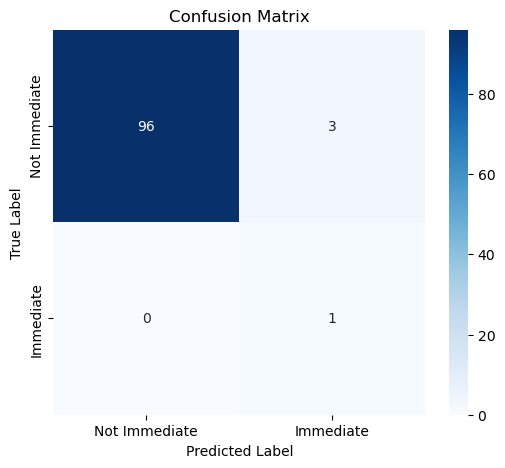

Mean Predicted Probability: 1.000
Undereporting % (predicted < true) of wrong predictions: 100.00%
Overreporting % (predicted > true) of wrong predictions: 0.00%

Triage Level: Emergent
Accuracy: 0.333
AUC: 0.500
Confusion Matrix:
[[76 12]
 [ 6  6]]


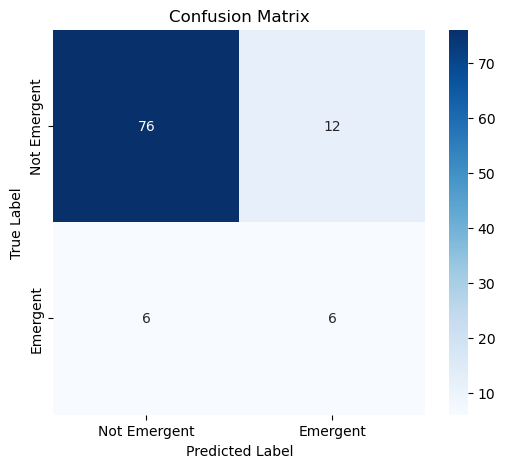

Mean Predicted Probability: 1.000
Undereporting % (predicted < true) of wrong predictions: 100.00%
Overreporting % (predicted > true) of wrong predictions: 0.00%

Triage Level: Urgent
Accuracy: 0.609
AUC: 0.500
Confusion Matrix:
[[30 18]
 [24 28]]


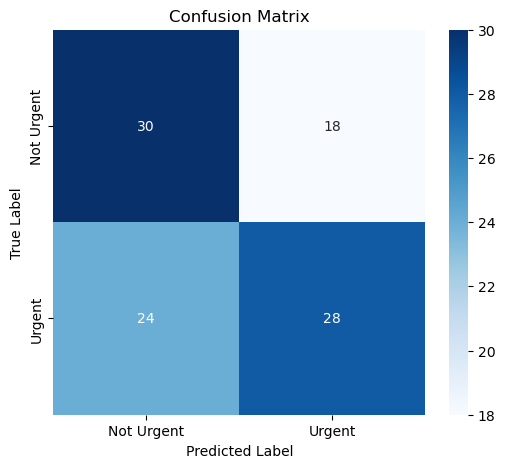

Mean Predicted Probability: 1.000
Undereporting % (predicted < true) of wrong predictions: 83.33%
Overreporting % (predicted > true) of wrong predictions: 16.67%

Triage Level: Semi-urgent
Accuracy: 0.483
AUC: 0.500
Confusion Matrix:
[[55 15]
 [16 14]]


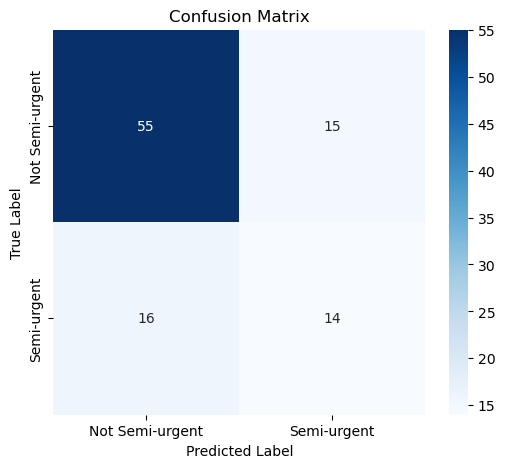

Mean Predicted Probability: 1.000
Undereporting % (predicted < true) of wrong predictions: 6.67%
Overreporting % (predicted > true) of wrong predictions: 93.33%

Triage Level: Nonurgent
Accuracy: 0.333
AUC: 0.500
Confusion Matrix:
[[93  2]
 [ 4  1]]


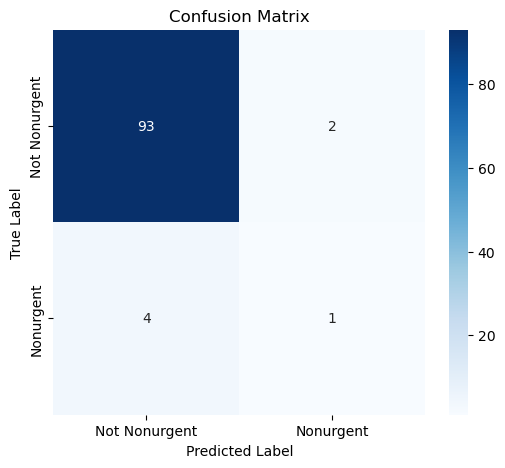

Mean Predicted Probability: 1.000
Undereporting % (predicted < true) of wrong predictions: 0.00%
Overreporting % (predicted > true) of wrong predictions: 100.00%

No cases of Triage Level: NA



In [312]:
per_triage_level_metrics(true_labels, predictions, all_probabilities, levels)

# EXTRA STUFF

1. Run the pipeline for the whole of train 
For each triage level + global:
    - 1.1 Accuracy
    - 1.2 AUC
    - 1.3 Confusion matrix
    - 1.4 Undereporting %
    - 1.5 Overreporting %
    - 1.6 Mean proability
    - 1.7 XAI?
2. How the input affects the performance of the model
    - 2.1 Drop one variable at a time in the input and see how the accuarcy or AUC varies for each triage level

    - Age and Gender 
    - Arrival mode
    - Reasons
    - Vitals
    - Pain Severity
    - Injury
    - Chronic Conditions
    - Causes

3. With R1
    - (i) Same scoring as v3
    - 3.1 How often was there a conflict reported for each triage level
    - 3.2 It overeporting or underreporting
    - 3.3 Histogram over causes of conflict

    Causes of conflict
    1. Medical Accuracy
    2. Wrong inference of data
    3. Biased opinion
    4. Others

In [ ]:
import tiktoken

# Get the encoding for a specific model. 
# For example, using the "gpt2" encoding which is common for many OpenAI models.
encoding = tiktoken.get_encoding("gpt2")

# Example text (triage label)
text = "II"

# Encode the text into tokens
tokens = encoding.encode(text)
print("Tokens:", tokens)

# To see the tokens as strings (if needed), you can decode each token:
decoded_tokens = [encoding.decode([token]) for token in tokens]
print("Decoded Tokens:", decoded_tokens)

if len(tokens) == 1:
    print(f'"{text}" is a single token.')
else:
    print(f'"{text}" is split into {len(tokens)} tokens.')

Tokens: [3978]
Decoded Tokens: ['II']
"II" is a single token.


In [326]:

# print("\n".join(textwrap.wrap(dataset["train"][0]["text_data"], width=120)))  # Inspect one formatted example
# print(dataset["train"][0]["triage_level"])  # Inspect one formatted example
# out = call_deepseek_v3(dataset["train"][0]["text_data"])
# pred_out = triage_mapping.get(out.get("text")["triage_level"])
# pred_out2 = out.get("probability")
# print("\nGround Truth Triage Level:\n    ", pred_out)

In [327]:
# pretty_print_decision(out)